In [101]:
# Main Libraries 

import matplotlib.pyplot as plt
from feature_engine.encoding import OneHotEncoder
import sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pandas 
import numpy 
import nltk
import re
%matplotlib inline

##### Pre-processing part

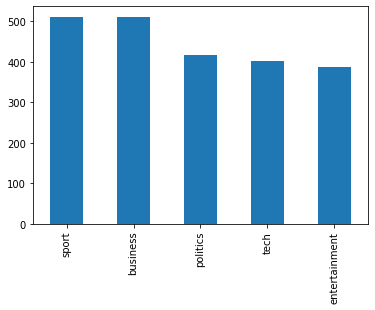

In [62]:
# Loading Data set
DATA = r'..\search_engines\data_base\bbc-news-data.csv'
df = pandas.read_csv(DATA, sep = '\t')
df.category.value_counts().plot(kind='bar');

##### Classes and functions

- The Data frame only contains content and title.
- I used bert to extract the top 3 phrases from each news.
- I did this because I want to write another program to extract keywords from documents , send them to a data base 
re-train the model and follow thi cycle.

In [64]:
# Process keywords 
class extract_keywords_keybert (sklearn.base.BaseEstimator, 
                        sklearn.base.TransformerMixin):
    
    """KeyBERT Must be imported, as dependence"""
    
    def __init__(self, variable:list, extractor ):
        super().__init__()
        
        if not isinstance(variable, list):
            raise ValueError ("feature must be a list")
            
        self.variable = variable
        self.key_extractor = extractor
        self.all_key_words = []
            
    def fit (self, X :pandas.DataFrame , y:pandas.Series = None):
        return self 
    
    def transform( self, X:pandas.DataFrame) -> pandas.DataFrame:
        
        def extracting_keywords (row:str) -> list:
            """Initiate tranformer , extract keywords into a list"""
            
            keywords_ = (self.key_extractor.extract_keywords(docs=row,
                                                             keyphrase_ngram_range = (1,2),
                                                             stop_words ='english',
                                                             top_n = 3,
                                                             use_mmr = True,
                                                             diversity = .6))
            
            keywords_ = [word[0] for word in keywords_]
            return keywords_
            
        
        # create a copy 
        X = X.copy()
        
        for col in self.variable:
            X[col+str("_t")] = X[col].apply(lambda row : extracting_keywords(row))
        
        return X

In [21]:
# Write a fuction for one hot enconding 
Categories = ['category']
Title = ['title']
Content = ['content']

# Extract Keywords
from keybert import KeyBERT
kw_model = KeyBERT()

# ----> Creating Pipelines 
Pipeline_ = sklearn.pipeline.Pipeline([
    
    # === OneHotEncoder ===
    ("OneHotEncoder",
      OneHotEncoder(variables=Categories)),
    
    # === Keywords Extraction ===
    ("keywords_title_extraction",
     extract_keywords_keybert(Title,kw_model)),
    
    ("keywords_content_extraction",
     extract_keywords_keybert(Content,kw_model))
])


In [22]:
engine = Pipeline_.fit_transform(df)
engine.head(5)
# engine.to_csv("anynameyouwant.csv")

,filename,title,content,category_business,category_entertainment,category_politics,category_sport,category_tech,title_t,content_t
0,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...,1,0,0,0,0,"[warner profit, boost time, ad sales]","[aol market, timewarner said, 9bn profits]"
1,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...,1,0,0,0,0,"[gains greenspan, dollar, speech]","[china currency, deficit concerns, mr greenspan]"
2,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...,1,0,0,0,0,"[loan claim, yukos unit, buyer faces]","[rosneft repay, yugansk assets, law exists]"
3,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...,1,0,0,0,0,"[ba profits, fuel prices, high]","[fuel surcharges, ba year, price aviation]"
4,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...,1,0,0,0,0,"[pernod takeover, lifts domecq, talk]","[pernod shares, uk drinks, seagram purchase]"


##### Search Engines

In [107]:
def extract_best_indices(m, topk, mask=None):
    """
    Use sum of the cosine distance over all tokens.
    m (np.array): cos matrix of shape (nb_in_tokens, nb_dict_tokens)
    topk (int): number of indices to return (from high to lowest in order)
    """
    # return the sum on all tokens of cosinus for each sentence
    if len(m.shape) > 1:
        cos_sim = numpy.mean(m, axis=0) 
    else: 
        cos_sim = m
    index = numpy.argsort(cos_sim)[::-1] # from highest idx to smallest score 
    if mask is not None:
        assert mask.shape == m.shape
        mask = mask[index]
    else:
        mask = numpy.ones(len(cos_sim))
    mask = numpy.logical_or(cos_sim[index] != 0, mask) #eliminate 0 cosine distance
    best_index = index[mask][:topk]  
    return best_index

In [15]:
# 1 Connect to my Database (skip because it is in my data frame)
NDATA = r'..\search_engines\data_base\bbc-tokenized.csv'
database = pandas.read_csv(NDATA, sep =',')
database.tail(2)

,Unnamed: 0,filename,title,content,category_business,category_entertainment,category_politics,category_sport,category_tech,title_t,content_t
2223,2223,400.txt,US cyber security chief resigns,The man making sure US computer networks are ...,0,0,0,0,1,"['chief resigns', 'cyber security', 'security ...","['department cybersecurity', 'yoran took', 'ma..."
2224,2224,401.txt,Losing yourself in online gaming,"Online role playing games are time-consuming,...",0,0,0,0,1,"['online gaming', 'losing', 'losing online']","['gaming addiction', 'huddersfield scare', 'on..."


##### Search by Keywords only

- This is search engine is basically a filter it search the words that you provide and find the articles link to those keywords
which means that it depends on how well the "keywords" describe the artical and also the number of keywords

In [97]:
def search_bar(keywords:str,category:str) -> pandas.DataFrame:
    """filter based on differnet keywords and categories
    Arg: 
        keywords: must be string 
        category: must be string (optional)
        
    Return:
        DataFrame"""


    # Connecting to Database    
    tmp_filter = database


    # limiting the Data by Frist Criteria and Kewords
    both_keyword_category= [bool(keywords) == True, bool(category)==True]
    only_keyword= [bool(keywords) == True, bool(category)==False]
    only_category= [bool(keywords) == False, bool(category)==True]
    all_keywords = r'\b(?:{})\b'.format('|'.join(map(re.escape, keywords.split(" "))))
    cols_return = ['title','content','filename']
    
    if all(both_keyword_category):
        tmp_criteria= [str('category_')+str(name) for name in category.split(" ")]
        tmp_filter =  tmp_filter[(tmp_filter[tmp_criteria]==1).any(axis=1)]
        tmp_filter =  tmp_filter[tmp_filter.content_t.str.contains(all_keywords)]
        return tmp_filter[cols_return] # type: ignore

    elif all(only_keyword):
        tmp_filter =  tmp_filter[tmp_filter.content_t.str.contains(all_keywords)]
        return tmp_filter[cols_return] # type: ignore

    elif all(only_category):
        tmp_criteria= [str('category_')+str(name) for name in category.split(" ")]
        tmp_filter =  tmp_filter[(tmp_filter[tmp_criteria]==1).any(axis=1)]
        return tmp_filter[cols_return]

#####  Searching by words frequency

In [103]:
# Importing Stopwords 
Stop_words = set(nltk.corpus.stopwords.words('english'))
min_words = 5
max_words = 300

def tokenizer_ (sentence:str,
                stopwords=Stop_words,
                lemmatize=True,
                min_words:int = min_words ,
                max_words:int = max_words):

    """ Lemmatize, tokenize, and remove stop words"""
    
    if lemmatize:
        # Initiate lemmatization
        stemmer = nltk.stem.WordNetLemmatizer()
        
        # Initiate Tokenizer
        tokens = [stemmer.lemmatize(word) for word in nltk.tokenize.word_tokenize(sentence)]
    
    else:
        tokens = [ word for word in nltk.tokenize.word_tokenize(sentence)]

        
    token = [word for word in tokens if (len(word)>min_words) and (len(word)<max_words)and (word not in stopwords)]
    
    return token

In [104]:
# Preprocessing corpus
token_stop = tokenizer_(' '.join(Stop_words), lemmatize=False)

Vec = (sklearn.feature_extraction.text.
       TfidfVectorizer(stop_words = Stop_words,
                       tokenizer=tokenizer_))

Vec_matrix = Vec.fit_transform(database['content'].values)
Vec_matrix.shape

(2225, 22668)

In [105]:
def search_bar_2 (sentence:str)-> pandas.DataFrame:
    """Return the data base sentences with cosine similarity"""
    
    # Transform sentences
    tokens = [str(token) for token in tokenizer_(sentence)]
    vector = Vec.transform(tokens)
    
    # Matric with similarity between query and databse
    tmp_mat = sklearn.metrics.pairwise.cosine_similarity(vector,Vec_matrix)
    
    # Best cosine distance for each token 
    best_index = extract_best_indices(tmp_mat, topk=3)
    
    return database.iloc[best_index, 3]

In [112]:
sentence = 'a new about weapons'
result = search_bar_2 (sentence)

for res in result:
    print(res)
    print()
    print("\n ----------------------- \n")

 UK Foreign Secretary Jack Straw has defended plans to end the European Union's arms embargo on China, despite opposition from the US and Japan.  Mr Straw, visiting Beijing, noted arms embargoes applied to China, Burma and Zimbabwe but not to North Korea, which he said had a terrible rights record. The EU imposed its arms ban on China in 1989 after troops opened fire on protestors in Tiananmen Square. Mr Straw also signed a deal on China-UK tourism. It is expected this would increase the number of Chinese tourists by 40,000 per year, providing $120m in revenue. China has in the past said it sees the weapons ban as politically driven, and does not want it lifted in order to buy more weapons. Mr Straw, speaking at a joint news conference with Chinese Foreign Minister Li Zhaoxing, stressed this point. "The result of any decision [to lift the arms embargo] should not be an increase in arms exports from European Union member states to China, either in quantitative or qualitative terms," Mr 

#####  Searching by Meaning

-Semantic search seeks to improve search accuracy by understanding the content of the search query. In contrast to traditional search engines which only find documents based on lexical matches, semantic search can also find synonyms

In [42]:
from sentence_transformers import SentenceTransformer, util
import tensorflow 
import torch

In [64]:
# Process keywords 
class WordEmbedding_Transformer (sklearn.base.BaseEstimator, 
                        sklearn.base.TransformerMixin):
    
    """download all-MiniLM-L6-v2"""
    
    def __init__(self,pre_train_model:str) :
        super().__init__()
    
        self.pre_train_model = pre_train_model
        self.model_ = SentenceTransformer(self.pre_train_model)
            
    def fit (self, X :numpy.array , y:numpy.array = None):
        return self 
    
    def transform(self,X :numpy.array) -> tensorflow.Tensor:
        X = self.model_.encode(X, convert_to_tensor = True)
        return X

class WordEmbedding_Comparing (sklearn.base.BaseEstimator, 
                            sklearn.base.TransformerMixin):
    def __init__(self,corpus:str) :
        super().__init__()
        self.corpus = corpus

    def fit(self,X:numpy.array, y:numpy.array = None):
        return self
    
    def transform(self,X :numpy.array) -> tensorflow.Tensor:
        cosine_score = util.pytorch_cos_sim(X,self.corpus)[0]
        N_top_results = torch.topk(cosine_score, k=5)
        return N_top_results

class Top_Results (sklearn.base.BaseEstimator, 
                            sklearn.base.TransformerMixin):
    def __init__(self) :
        super().__init__()
        self.top_n = []

    def fit(self,X:numpy.array, y:numpy.array = None):
        return self
    
    def transform(self,X :numpy.array):
        for score, idx in zip(X[0], X[1]):
            score = score.cpu().data.numpy() 
            idx = self.top_n .append(idx.cpu().data.numpy())
            
        return self.top_n


In [86]:
# Enconding the Whole data Set
embedding_corpus = WordEmbedding_Transformer('all-MiniLM-L6-v2').fit_transform(database.content)

c:\Users\Marvin Garcia\Anaconda3\lib\site-packages\huggingface_hub\file_download.py:563: FutureWarning: `cached_download` is the legacy way to download files from the HF hub, please consider upgrading to `hf_hub_download`
  FutureWarning,


In [79]:
Pipeline_2 = sklearn.pipeline.Pipeline([
    # === Transforming ===
    ("Emebdding Query",
     WordEmbedding_Transformer('all-MiniLM-L6-v2')),

    ("Comparing",
     WordEmbedding_Comparing(embedding_corpus)),

    ("Top_N",
    Top_Results())
])

c:\Users\Marvin Garcia\Anaconda3\lib\site-packages\huggingface_hub\file_download.py:563: FutureWarning: `cached_download` is the legacy way to download files from the HF hub, please consider upgrading to `hf_hub_download`
  FutureWarning,


In [83]:
def search_by_meaning(indexes):
    return database.iloc[indexes][['title','content']] # type: ignore

In [85]:
result = Pipeline_2.fit_transform("china has many problems")
search_by_meaning(result)

,title,content
15,China keeps tight rein on credit,China's efforts to stop the economy from over...
1897,China 'to overtake US net use',The Chinese net-using population looks set to...
2207,China 'ripe' for media explosion,Asia is set to drive global media growth to 2...
497,Millions go missing at China bank,Two senior officials at one of China's top co...
471,China suspends 26 power projects,China has ordered a halt to construction work...
15,China keeps tight rein on credit,China's efforts to stop the economy from over...
1897,China 'to overtake US net use',The Chinese net-using population looks set to...
2207,China 'ripe' for media explosion,Asia is set to drive global media growth to 2...
497,Millions go missing at China bank,Two senior officials at one of China's top co...
471,China suspends 26 power projects,China has ordered a halt to construction work...
